# Attempting to Quantify Gender Differences in Kaggle Dev Survey 

In this notebook I:

- First visualize and normalize gender differences in the sample
Run a multiple linear regression to understand which factors contribute most to earning potential.
- Run a lasso regression to narrow variable set and try to quantify the extent gender impacts earning potential.
- Run a random forest on same data to evaluate feature importance (A nonlinear model like this is a good check).
- Compare models for just subsets of women and men to hopefully normalize for more variables.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt #likley won't be used much as i'm experimenting with plotly 
import plotly.graph_objects as go #you will be learning how go and px work with me! 
import plotly.express as px 

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
url = 'https://raw.githubusercontent.com/akibiqbal98/2021-Kaggle-Data-Science-Profession-Survey/master/kaggle_survey_2021_responses.csv'
df = pd.read_csv(url)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,195,201,285,286,287,288,289,290,291,292) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time from Start to Finish (seconds)                           Q1  \
0               Duration (in seconds)  What is your age (# years)?   
1                                 910                        50-54   
2                                 784                        50-54   
3                                 924                        22-24   
4                                 575                        45-49   

                                       Q2  \
0  What is your gender? - Selected Choice   
1                                     Man   
2                                     Man   
3                                     Man   
4                                     Man   

                                          Q3  \
0  In which country do you currently reside?   
1                                      India   
2                                  Indonesia   
3                                   Pakistan   
4                                     Mexico   

                                                  Q4  \
0  What is the highest level of formal education ...   
1                                  Bachelor’s degree   
2                                    Master’s degree   
3                                    Master’s degree   
4                                    Doctoral degree   

                                                  Q5  \
0  Select the title most similar to your current ...   
1                                              Other   
2                            Program/Project Manager   
3                                  Software Engineer   
4                                 Research Scientist   

                                                  Q6  \
0  For how many years have you been writing code ...   
1                                         5-10 years   
2                                          20+ years   
3                                          1-3 years   
4                                          20+ years   

                                           Q7_Part_1  \
0  What programming languages do you use on a reg...   
1                                             Python   
2                                                NaN   
3                                             Python   
4                                             Python   

                                           Q7_Part_2  \
0  What programming languages do you use on a reg...   
1                                                  R   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                           Q7_Part_3  \
0  What programming languages do you use on a reg...   
1                                                NaN   
2                                                SQL   
3                                                NaN   
4                                                NaN   

                                           Q7_Part_4  \
0  What programming languages do you use on a reg...   
1                                                NaN   
2                                                  C   
3                                                NaN   
4                                                NaN   

                                           Q7_Part_5  \
0  What programming languages do you use on a reg...   
1                                                NaN   
2                                                C++   
3                                                C++   
4                                                NaN   

                                           Q7_Part_6  \
0  What programming languages do you use on a reg...   
1                                                NaN   
2                                               Java   
3                                               Java   
4                                            

In [3]:
df.shape

(25974, 369)

In [4]:
df_fin = df.iloc[1:, :]

In [5]:
#create a dictionary for questions 
Questions = {}

#create list of questions 
#not very efficient, but keeps things ordered
qnums = list(dict.fromkeys([i.split('_')[0] for i in df_fin.columns]))

#add data for each question to key value pairs in dictionary
for i in qnums:
    if i in ['Q1','Q2','Q3']: #since we are using .startswith() below this prevents all questions that start with 
        Questions[i] = df_fin[i] #[1,2,3] from going in the key value pair (Example in vid)
    else:
        Questions[i] = df_fin[[q for q in df_fin.columns if q.startswith(i)]]

In [6]:
# create disctionary for different gender selections 
Genders = {}
for i in df_fin.Q2.unique():
    Genders[i] = df_fin[df_fin.Q2 == i]

In [7]:
#look at gender distribution
df_fin.Q2.value_counts()/ df_fin.Q2.value_counts().sum()

Man                        0.793054
Woman                      0.188272
Prefer not to say          0.013668
Nonbinary                  0.003388
Prefer to self-describe    0.001617
Name: Q2, dtype: float64

In [8]:
#filter dataframe for male & female for simplicity (not that prefer not & nonbinary aren't important!)
df_mf = df_fin[df_fin.Q2.isin(['Man','Woman'])] 

In [9]:
#DS is clearly already a male dominated field (or at least this sample of kaggle users is)
df_mf.Q2.value_counts()/ df_mf.Q2.value_counts().sum() 

Man      0.808145
Woman    0.191855
Name: Q2, dtype: float64

In [10]:
#Female Distribution by Role 
fig= px.histogram(df_mf,x='Q4',color ='Q2')
fig.show()

In [11]:
#Female Distribution by Role Normalized by sample of respective population 
fig= px.histogram(df_mf,x='Q4',color ='Q2', histnorm='probability density')
fig.show()

In [12]:
#Percent more or less than distribution of the average population of women (Absolute)
male_degrees = df_mf[df_mf.Q2 == 'Man'].Q4.value_counts()
female_degrees = df_mf[df_mf.Q2 == 'Woman'].Q4.value_counts()
total_degrees = df_mf.Q4.value_counts()
more_women = (female_degrees/total_degrees)-.1918 #greater proportion of women than sample
more_women['Color'] = np.where(more_women.values <0, 'blue','red')
fig = go.Figure(go.Bar(x=(female_degrees/total_degrees).index, y= (female_degrees/total_degrees).values-.197, marker_color=more_women.Color))
fig.update_layout(title= "Level of Female Education Relative to AVG of Sample (19.18%)")
fig.show()

In [13]:
#Female Distribution by Country
fig= px.histogram(df_mf,x='Q3',color ='Q2')
fig.update_xaxes(categoryorder= "total descending")
fig.show()

In [14]:
male_country = df_mf[df_mf.Q2 == 'Man'].Q3.value_counts()
female_country = df_mf[df_mf.Q2 == 'Woman'].Q3.value_counts()
total_country = df_mf.Q3.value_counts()

In [15]:
total_country

India                                                   7337
United States of America                                2555
Other                                                   1231
Japan                                                    904
China                                                    778
Brazil                                                   745
Russia                                                   734
Nigeria                                                  701
United Kingdom of Great Britain and Northern Ireland     542
Pakistan                                                 529
Egypt                                                    479
Germany                                                  460
Spain                                                    446
Indonesia                                                432
Turkey                                                   409
France                                                   393
South Korea             

In [16]:
female_country

India                                                   1656
United States of America                                 606
Other                                                    227
Egypt                                                    127
United Kingdom of Great Britain and Northern Ireland     113
Nigeria                                                  107
China                                                    106
Russia                                                   104
Indonesia                                                 96
Germany                                                   81
Brazil                                                    81
Pakistan                                                  81
Taiwan                                                    81
Turkey                                                    79
South Korea                                               72
Japan                                                     68
France                  

In [17]:
#Percent more or less than distribution of the average population of women 
more_women = (female_country/total_country)-.197 #greater proportion of women than sample
more_women['Color'] = np.where(more_women.values <0, 'blue','red')
fig = go.Figure(go.Bar(x=(female_country/total_country).index, y= (female_country/total_country).values-.197, marker_color=more_women.Color))
fig.update_layout(title= "Amount of Women By Country Relative to AVG of Sample (19.7%)")
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

**Notes:**
> As we can see from the graph Tunisia has more avarage female than all other countries. 

> On the other hand japan's tech is mostly dominating by male.

In [18]:
#function for creating new graphs 
def create_norm_graph(qnum, data, title, baseline):
    male = data[data.Q2 == 'Man'][qnum].value_counts()
    female = data[data.Q2 == 'Woman'][qnum].value_counts()
    total = data[qnum].value_counts()
    more_women = (female/total)-baseline #greater proportion of women than sample
    more_women['Color'] = np.where(more_women.values <0, 'blue','red')
    fig = go.Figure(go.Bar(x=(female/total).index, y= (female/total).values-baseline, marker_color=more_women.Color))
    fig.update_layout(title= title)
    fig.update_layout(xaxis={'categoryorder':'total descending'})
    fig.show()
    return 

In [19]:
# which countries have the most relative female representitives in the survey?
create_norm_graph('Q3',df_mf,"Amount of Women By Country Relative to AVG of Sample (19.18%)",.1918)

In [20]:
#Which roles have the most women relative to the baseline?
create_norm_graph('Q5',df_mf,"Amount of Women By Role Relative to AVG of Sample (19.7%)",.1918)

In [21]:
#create new baseline for only employed people
df_workers_mf = df_mf[~df_mf['Q5'].isin(['Student','Currently not employed'])]
df_workers_mf.Q2.value_counts()/df_workers_mf.Q2.value_counts().sum()

Man      0.830973
Woman    0.169027
Name: Q2, dtype: float64

In [22]:
# Women's experience 
create_norm_graph('Q6',df_workers_mf,"Amount of Women By Experience Relative to AVG of Sample (16.9%)",.169)

#absolute number is a lot lower 
df_workers_mf.Q6.value_counts()

1-3 years                    4163
< 1 years                    2893
3-5 years                    2697
5-10 years                   2509
10-20 years                  1965
20+ years                    1705
I have never written code     947
Name: Q6, dtype: int64

In [23]:
#by income level 
create_norm_graph('Q25',df_workers_mf,"Amount of Women By Income Level Relative to AVG of Sample (16.9%)",.169)
df_workers_mf.Q25.value_counts()

$0-999              3295
1,000-1,999          962
10,000-14,999        940
30,000-39,999        730
100,000-124,999      703
5,000-7,499          690
50,000-59,999        684
40,000-49,999        676
20,000-24,999        579
2,000-2,999          567
15,000-19,999        567
60,000-69,999        544
7,500-9,999          543
25,000-29,999        462
70,000-79,999        456
4,000-4,999          452
80,000-89,999        385
150,000-199,999      381
3,000-3,999          380
125,000-149,999      373
90,000-99,999        340
200,000-249,999      175
300,000-499,999       87
250,000-299,999       70
>$1,000,000           52
$500,000-999,999      31
Name: Q25, dtype: int64

In [24]:
#graph for just data scientists 
df_mf_ds= df_mf[df_mf['Q5'] =='Data Scientist']
create_norm_graph('Q25',df_mf_ds,"Amount of Women By Country Relative to AVG of Sample (16.9%)",.169)

In [25]:
#count for perspective, some sample size issues here
df_mf_ds.Q25.value_counts()

$0-999              719
1,000-1,999         208
100,000-124,999     185
10,000-14,999       163
30,000-39,999       159
50,000-59,999       134
150,000-199,999     127
40,000-49,999       122
60,000-69,999       114
15,000-19,999       113
125,000-149,999     112
25,000-29,999       108
20,000-24,999       108
2,000-2,999         101
80,000-89,999       101
5,000-7,499          98
70,000-79,999        96
7,500-9,999          86
90,000-99,999        82
4,000-4,999          72
3,000-3,999          68
200,000-249,999      53
300,000-499,999      23
>$1,000,000          14
250,000-299,999      14
$500,000-999,999      7
Name: Q25, dtype: int64

In [26]:
#graph for US 
df_mf_US= df_mf[df_mf['Q3'] =='United States of America']
create_norm_graph('Q25',df_mf_US,"Amount of Women By Country Relative to AVG of Sample (16.9%)",.169)

In [27]:
#graph for India 
df_mf_US= df_mf[df_mf['Q3'] =='India']
create_norm_graph('Q25',df_mf_US,"Amount of Women By Country Relative to AVG of Sample (16.9%)",.169)

In [28]:
#Income by role (awful graph I know)
fig= px.histogram(df_fin.dropna(subset=['Q25','Q5']),x='Q25',color ='Q5')
fig.update_xaxes(categoryorder= "total descending")
fig.show()

In [29]:
#Income by experience 
fig= px.histogram(df_fin.dropna(subset=['Q25','Q6']),x='Q25',color ='Q6')
fig.update_xaxes(categoryorder= "total descending")
fig.show()

In [30]:
#Income by education
fig= px.histogram(df_fin.dropna(subset=['Q25','Q4']),x='Q25',color ='Q4')
fig.update_xaxes(categoryorder= "total descending")
fig.show()

## Building a Model

- **I thought it made more sense to use a regression here to try to predict salary. Although it will be very rough around the edges, I think converting the salaries from categorical to numeric will allow us to more easily interperet the data.**

> convert dollar ranges to numeric 

> explore converting other continuious variables 

>build model with just gender 

In [31]:
#replace '$',',','>' in data 
df_model = df_fin.dropna(subset=['Q25'])
df_model['salary_cleaned'] = df_model.Q25.apply(lambda x: str(x).replace('$','').replace(',','').replace('>','').strip())
df_model.salary_cleaned.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0-999            3369
1000-1999         969
10000-14999       950
30000-39999       741
100000-124999     725
5000-7499         699
50000-59999       697
40000-49999       688
20000-24999       587
2000-2999         575
15000-19999       573
7500-9999         552
60000-69999       551
25000-29999       470
70000-79999       464
4000-4999         456
150000-199999     392
80000-89999       391
3000-3999         380
125000-149999     379
90000-99999       350
200000-249999     177
300000-499999      91
250000-299999      75
1000000            58
500000-999999      32
Name: salary_cleaned, dtype: int64

In [32]:
#create min range and max range for salary 
df_model['salary_min'] = df_model.salary_cleaned.apply(lambda x: 500000 if '-' not in x else int(x.split('-')[0]))
df_model['salary_max'] = df_model.salary_cleaned.apply(lambda x: 500000 if '-' not in x else int(x.split('-')[1]))

df_model.salary_max.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



999       3369
1999       969
14999      950
39999      741
124999     725
7499       699
59999      697
49999      688
24999      587
2999       575
19999      573
9999       552
69999      551
29999      470
79999      464
4999       456
199999     392
89999      391
3999       380
149999     379
99999      350
249999     177
499999      91
299999      75
500000      58
999999      32
Name: salary_max, dtype: int64

In [33]:
#Convert to rough continuous variable 
df_model['aprox_salary'] = (df_model.salary_min+df_model.salary_max)/2
df_model.aprox_salary.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



499.5       3369
1499.5       969
12499.5      950
34999.5      741
112499.5     725
6249.5       699
54999.5      697
44999.5      688
22499.5      587
2499.5       575
17499.5      573
8749.5       552
64999.5      551
27499.5      470
74999.5      464
4499.5       456
174999.5     392
84999.5      391
3499.5       380
137499.5     379
94999.5      350
224999.5     177
399999.5      91
274999.5      75
500000.0      58
749999.5      32
Name: aprox_salary, dtype: int64

In [34]:
#simple linear regression just gender 
import statsmodels.api as sm 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [35]:
#filter for men & women 
df_model_fin = df_model[df_model.Q2.isin(['Man','Woman'])] 
#filter for workers 
df_model_fin = df_model_fin[~df_model_fin['Q5'].isin(['Student','Currently not employed'])]
df_model_fin.drop('Time from Start to Finish (seconds)', axis =1, inplace = True)

In [36]:
df_model_fin.isnull().any()

Q1                False
Q2                False
Q3                False
Q4                False
Q5                False
Q6                False
Q7_Part_1          True
Q7_Part_2          True
Q7_Part_3          True
Q7_Part_4          True
Q7_Part_5          True
Q7_Part_6          True
Q7_Part_7          True
Q7_Part_8          True
Q7_Part_9          True
Q7_Part_10         True
Q7_Part_11         True
Q7_Part_12         True
Q7_OTHER           True
Q8                 True
Q9_Part_1          True
Q9_Part_2          True
Q9_Part_3          True
Q9_Part_4          True
Q9_Part_5          True
Q9_Part_6          True
Q9_Part_7          True
Q9_Part_8          True
Q9_Part_9          True
Q9_Part_10         True
Q9_Part_11         True
Q9_Part_12         True
Q9_OTHER           True
Q10_Part_1         True
Q10_Part_2         True
Q10_Part_3         True
Q10_Part_4         True
Q10_Part_5         True
Q10_Part_6         True
Q10_Part_7         True
Q10_Part_8         True
Q10_Part_9      

In [37]:
# create dummy variables, this is needed because essentially all our data is categorical
model_dummies = pd.get_dummies(df_model_fin)
model_dummies

salary_min  salary_max  aprox_salary  Q1_18-21  Q1_22-24  Q1_25-29  \
1           25000       29999       27499.5         0         0         0   
2           60000       69999       64999.5         0         0         0   
3               0         999         499.5         0         1         0   
4           30000       39999       34999.5         0         0         0   
5           30000       39999       34999.5         0         0         0   
...           ...         ...           ...       ...       ...       ...   
25967        3000        3999        3499.5         0         0         0   
25968       80000       89999       84999.5         0         0         0   
25969       15000       19999       17499.5         0         0         0   
25971           0         999         499.5         0         0         0   
25973           0         999         499.5         1         0         0   

       Q1_30-34  Q1_35-39  Q1_40-44  Q1_45-49  Q1_50-54  Q1_55-59  Q1_60-69  \
1             0         0         0         0         1         0         0   
2             0         0         0         0         1         0         0   
3             0         0         0         0         0         0         0   
4             0         0         0         1         0         0         0   
5             0         0         0         1         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
25967         1         0         0         0         0         0         0   
25968         0         1         0         0         0         0         0   
25969         1         0         0         0         0         0         0   
25971         0         0         0         0         1         0         0   
25973         0         0         0         0         0         0         0   

       Q1_70+  Q2_Man  Q2_Woman  Q3_Algeria  Q3_Argentina  Q3_Australia  \
1           0       1         0           0             0             0   
2           0       1         0           0             0             0   
3           0       1         0           0             0             0   
4           0       1         0           0             0             0   
5           0       1         0           0             0             0   
...       ...     ...       ...         ...           ...           ...   
25967       0       1         0           0             0             0   
25968       0       1         0           0             0             0   
25969       0       1         0           0             0             0   
25971       0       1         0           0             0             0   
25973       0       1         0           0             0             0   

       Q3_Austria  Q3_Bangladesh  Q3_Belarus  Q3_Belgium  Q3_Brazil  \
1               0              0           0           0          0   
2               0              0           0           0          0   
3               0              0           0           0          0   
4               0              0           0           0          0   
5               0              0           0           0          0   
...           ...            ...         ...         ...        ...   
25967           0              0           0           0          0   
25968           0              0           0           0          0   
25969           0              0           0           0          0   
25971           0              0           0           0          0   
25973           0              0           0           0          0   

       Q3_Canada  Q3_Chile  Q3_China  Q3_Colombia  Q3_Czech Republic  \
1              0         0         0            0                  0   
2              0         0         0            0                  0   
3              0         0         0            0                  0   
4              0         0         0            0                  0   
5              0   

In [38]:
# We only need one gender in this case because we trimmed it to only have Men & Women
Y = model_dummies.aprox_salary
X = model_dummies.Q2_Man

In [39]:
#for statsmodels, we need to add a constant to create intercept 
X = sm.add_constant(X)

In [40]:
#fit model with data 
model = sm.OLS(Y,X)
results= model.fit()

In [41]:
#create summary report 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           aprox_salary   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     76.60
Date:                Sat, 29 Jan 2022   Prob (F-statistic):           2.31e-18
Time:                        14:21:35   Log-Likelihood:            -1.9032e+05
No. Observations:               15124   AIC:                         3.806e+05
Df Residuals:                   15122   BIC:                         3.807e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.046e+04   1417.489     21.489      0.000    2.77e+04    3.32e+04
Q2_Man      1.357e+04   1550.405      8.752      0.000    1.05e+04    1.66e+04
==============================================================================
Omnibus:                    13646.375   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           574418.426
Skew:                           4.301   Prob(JB):                         0.00
Kurtosis:                      31.940   Cond. No.                         4.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# create function to add additional questions to dataframe for easier processing
def qnums(question_list, dataframe):
    q_out = [] 
    for i in question_list:
        for j in dataframe.columns:
            if i == j.split('_')[0]:
                q_out.append(j)
    return dataframe.loc[:,q_out]
        
#create data for questions 2,4,5
q245 =  qnums(['Q2','Q4','Q5'], model_dummies)
q245

Q2_Man  Q2_Woman  Q4_Bachelor’s degree  Q4_Doctoral degree  \
1           1         0                     1                   0   
2           1         0                     0                   0   
3           1         0                     0                   0   
4           1         0                     0                   1   
5           1         0                     0                   1   
...       ...       ...                   ...                 ...   
25967       1         0                     1                   0   
25968       1         0                     1                   0   
25969       1         0                     1                   0   
25971       1         0                     0                   1   
25973       1         0                     1                   0   

       Q4_I prefer not to answer  Q4_Master’s degree  \
1                              0                   0   
2                              0                   1   
3                              0                   1   
4                              0                   0   
5                              0                   0   
...                          ...                 ...   
25967                          0                   0   
25968                          0                   0   
25969                          0                   0   
25971                          0                   0   
25973                          0                   0   

       Q4_No formal education past high school  Q4_Professional doctorate  \
1                                            0                          0   
2                                            0                          0   
3                                            0                          0   
4                                            0                          0   
5                                            0                          0   
...                                        ...                        ...   
25967                                        0                          0   
25968                                        0                          0   
25969                                        0                          0   
25971                                        0                          0   
25973                                        0                          0   

       Q4_Some college/university study without earning a bachelor’s degree  \
1                                                      0                      
2                                                      0                      
3                                                      0                      
4                                                      0                      
5                                                      0                      
...                                                  ...                      
25967                                                  0                      
25968                                                  0                      
25969                                                  0                      
25971                                                  0                      
25973                                                  0                      

       Q5_Business Analyst  Q5_DBA/Database Engineer  Q5_Data Analyst  \
1                        0                         0                0   
2                        0                         0                0   
3                        0                         0                0   
4                        0                         0                0   
5                        0                         0                0   
...                    ...                       ...              ...   
25967                    0                         0                1   
25968                    0                     

In [43]:
#drop one of the gender columns, it is redundant 
X = q245.drop('Q2_Man', axis=1)
X = sm.add_constant(X)

In [44]:
#build model with additional features education, gender, and role 
model = sm.OLS(Y,X)
results= model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           aprox_salary   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     40.02
Date:                Sat, 29 Jan 2022   Prob (F-statistic):          4.03e-145
Time:                        14:21:35   Log-Likelihood:            -1.8999e+05
No. Observations:               15124   AIC:                         3.800e+05
Df Residuals:                   15104   BIC:                         3.802e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                 3.678e+04   1151.392     31.944      0.000    3.45e+04     3.9e+04
Q2_Woman                                                             -1.361e+04   1525.002     -8.927      0.000   -1.66e+04   -1.06e+04
Q4_Bachelor’s degree                                                 -5899.5884   1361.398     -4.333      0.000   -8568.093   -3231.083
Q4_Doctoral degree                                                    2.921e+04   1737.300     16.815      0.000    2.58e+04    3.26e+04
Q4_I prefer not to answer                                            -1.209e+04   3542.502     -3.414      0.001    -1.9e+04   -5148.733
Q4_Master’s degree                                                    1.003e+04   1262.429      7.942      0.000    7552.250    1.25e+04
Q4_No formal education past high school                              -6843.2847   4137.956     -1.654      0.098    -1.5e+04    1267.610
Q4_Professional doctorate                                             2.355e+04   3719.680      6.332      0.000    1.63e+04    3.08e+04
Q4_Some college/university study without earning a bachelor’s degree -1177.5182   2441.507     -0.482      0.630   -5963.167    3608.130
Q5_Business Analyst                                                  -3922.0010   2358.436     -1.663      0.096   -8544.821     700.819
Q5_DBA/Database Engineer                                              4963.3893   5413.511      0.917      0.359   -5647.747    1.56e+04
Q5_Data Analyst                                                      -1.201e+04   1708.621     -7.027      0.000   -1.54e+04   -8657.261
Q5_Data Engineer                                                      4043.2596   2795.408      1.446      0.148   -1436.078    9522.597
Q5_Data Scientist                                                     7000.6400   1465.319      4.778      0.000    4128.437    9872.843
Q5_Developer Relations/Advocacy                                       1.053e+04   7126.228      1.478      0.139   -3433.410    2.45e+04
Q5_Machine Learning Engineer                                         -5103.2850   2001.637     -2.550      0.011   -9026.736   -1179.834
Q5_Other                                                              6329.6980   1650.641      3.835      0.000    3094.243    9565.153
Q5_Product Manager                                                    3.633e+04   3948.014      9.203      0.000    2.86e+04    4.41e+04
Q5_Program/Project Manager                                            1.511e+04   2481.968      6.088      0.000    1.02e+04       2e+04
Q5_Research Scientist                                                

In [45]:
#questions 2,4,5,7 add in programming languages 
        
q2457 =  qnums(['Q2','Q4','Q5','Q7'], model_dummies).drop('Q2_Man', axis=1)
q2457

Q2_Woman  Q4_Bachelor’s degree  Q4_Doctoral degree  \
1             0                     1                   0   
2             0                     0                   0   
3             0                     0                   0   
4             0                     0                   1   
5             0                     0                   1   
...         ...                   ...                 ...   
25967         0                     1                   0   
25968         0                     1                   0   
25969         0                     1                   0   
25971         0                     0                   1   
25973         0                     1                   0   

       Q4_I prefer not to answer  Q4_Master’s degree  \
1                              0                   0   
2                              0                   1   
3                              0                   1   
4                              0                   0   
5                              0                   0   
...                          ...                 ...   
25967                          0                   0   
25968                          0                   0   
25969                          0                   0   
25971                          0                   0   
25973                          0                   0   

       Q4_No formal education past high school  Q4_Professional doctorate  \
1                                            0                          0   
2                                            0                          0   
3                                            0                          0   
4                                            0                          0   
5                                            0                          0   
...                                        ...                        ...   
25967                                        0                          0   
25968                                        0                          0   
25969                                        0                          0   
25971                                        0                          0   
25973                                        0                          0   

       Q4_Some college/university study without earning a bachelor’s degree  \
1                                                      0                      
2                                                      0                      
3                                                      0                      
4                                                      0                      
5                                                      0                      
...                                                  ...                      
25967                                                  0                      
25968                                                  0                      
25969                                                  0                      
25971                                                  0                      
25973                                                  0                      

       Q5_Business Analyst  Q5_DBA/Database Engineer  Q5_Data Analyst  \
1                        0                         0                0   
2                        0                         0                0   
3                        0                         0                0   
4                        0                         0                0   
5                        0                         0                0   
...                    ...                       ...              ...   
25967                    0                         0                1   
25968                    0                         0                0   
25969                    0                         0                1 

In [46]:
X = q2457
X = sm.add_constant(X)

In [47]:
model = sm.OLS(Y,X)
results= model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           aprox_salary   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     38.77
Date:                Sat, 29 Jan 2022   Prob (F-statistic):          2.23e-230
Time:                        14:21:35   Log-Likelihood:            -1.8976e+05
No. Observations:               15124   AIC:                         3.796e+05
Df Residuals:                   15091   BIC:                         3.798e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                 2.999e+04   1553.009     19.308      0.000    2.69e+04     3.3e+04
Q2_Woman                                                             -1.217e+04   1513.802     -8.038      0.000   -1.51e+04   -9201.099
Q4_Bachelor’s degree                                                 -6194.9452   1355.292     -4.571      0.000   -8851.482   -3538.408
Q4_Doctoral degree                                                    2.693e+04   1741.826     15.463      0.000    2.35e+04    3.03e+04
Q4_I prefer not to answer                                            -1.117e+04   3496.562     -3.194      0.001    -1.8e+04   -4312.803
Q4_Master’s degree                                                    7593.3117   1267.085      5.993      0.000    5109.672    1.01e+04
Q4_No formal education past high school                              -7259.8215   4081.753     -1.779      0.075   -1.53e+04     740.910
Q4_Professional doctorate                                             2.179e+04   3687.081      5.910      0.000    1.46e+04     2.9e+04
Q4_Some college/university study without earning a bachelor’s degree -1712.7652   2413.201     -0.710      0.478   -6442.932    3017.402
Q5_Business Analyst                                                  -3619.7777   2337.903     -1.548      0.122   -8202.352     962.796
Q5_DBA/Database Engineer                                              -916.1607   5358.923     -0.171      0.864   -1.14e+04    9587.978
Q5_Data Analyst                                                      -1.367e+04   1719.438     -7.949      0.000    -1.7e+04   -1.03e+04
Q5_Data Engineer                                                      -659.7031   2785.755     -0.237      0.813   -6120.121    4800.715
Q5_Data Scientist                                                     4454.6208   1493.379      2.983      0.003    1527.418    7381.824
Q5_Developer Relations/Advocacy                                       1.112e+04   7045.967      1.578      0.115   -2694.428    2.49e+04
Q5_Machine Learning Engineer                                         -3293.1887   2017.578     -1.632      0.103   -7247.886     661.508
Q5_Other                                                              8402.8204   1641.712      5.118      0.000    5184.867    1.16e+04
Q5_Product Manager                                                    3.674e+04   3893.863      9.435      0.000    2.91e+04    4.44e+04
Q5_Program/Project Manager                                            1.573e+04   2449.506      6.421      0.000    1.09e+04    2.05e+04
Q5_Research Scientist                                                

In [48]:
#questions 2,3,4,5,7 add in country (huge boost in model performance)
        
q24573 =  qnums(['Q2','Q4','Q5','Q7','Q3'], model_dummies).drop('Q2_Man', axis=1)
q24573

Q2_Woman  Q4_Bachelor’s degree  Q4_Doctoral degree  \
1             0                     1                   0   
2             0                     0                   0   
3             0                     0                   0   
4             0                     0                   1   
5             0                     0                   1   
...         ...                   ...                 ...   
25967         0                     1                   0   
25968         0                     1                   0   
25969         0                     1                   0   
25971         0                     0                   1   
25973         0                     1                   0   

       Q4_I prefer not to answer  Q4_Master’s degree  \
1                              0                   0   
2                              0                   1   
3                              0                   1   
4                              0                   0   
5                              0                   0   
...                          ...                 ...   
25967                          0                   0   
25968                          0                   0   
25969                          0                   0   
25971                          0                   0   
25973                          0                   0   

       Q4_No formal education past high school  Q4_Professional doctorate  \
1                                            0                          0   
2                                            0                          0   
3                                            0                          0   
4                                            0                          0   
5                                            0                          0   
...                                        ...                        ...   
25967                                        0                          0   
25968                                        0                          0   
25969                                        0                          0   
25971                                        0                          0   
25973                                        0                          0   

       Q4_Some college/university study without earning a bachelor’s degree  \
1                                                      0                      
2                                                      0                      
3                                                      0                      
4                                                      0                      
5                                                      0                      
...                                                  ...                      
25967                                                  0                      
25968                                                  0                      
25969                                                  0                      
25971                                                  0                      
25973                                                  0                      

       Q5_Business Analyst  Q5_DBA/Database Engineer  Q5_Data Analyst  \
1                        0                         0                0   
2                        0                         0                0   
3                        0                         0                0   
4                        0                         0                0   
5                        0                         0                0   
...                    ...                       ...              ...   
25967                    0                         0                1   
25968                    0                         0                0   
25969                    0                         0                1 

In [49]:
X = q24573
X = sm.add_constant(X)

In [50]:
model = sm.OLS(Y,X)
results= model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           aprox_salary   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     67.92
Date:                Sat, 29 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:21:36   Log-Likelihood:            -1.8761e+05
No. Observations:               15124   AIC:                         3.754e+05
Df Residuals:                   15026   BIC:                         3.762e+05
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                 2.785e+04   1458.666     19.092      0.000     2.5e+04    3.07e+04
Q2_Woman                                                             -1.566e+04   1328.125    -11.791      0.000   -1.83e+04   -1.31e+04
Q4_Bachelor’s degree                                                 -1317.6186   1216.948     -1.083      0.279   -3702.985    1067.748
Q4_Doctoral degree                                                    1.775e+04   1532.710     11.578      0.000    1.47e+04    2.07e+04
Q4_I prefer not to answer                                            -2091.6081   3055.965     -0.684      0.494   -8081.672    3898.456
Q4_Master’s degree                                                    5421.6972   1115.313      4.861      0.000    3235.547    7607.847
Q4_No formal education past high school                              -4954.4166   3575.119     -1.386      0.166    -1.2e+04    2053.252
Q4_Professional doctorate                                             1.649e+04   3217.397      5.126      0.000    1.02e+04    2.28e+04
Q4_Some college/university study without earning a bachelor’s degree -3446.8738   2115.901     -1.629      0.103   -7594.298     700.550
Q5_Business Analyst                                                  -2314.3458   2036.883     -1.136      0.256   -6306.884    1678.192
Q5_DBA/Database Engineer                                             -8237.3045   4667.190     -1.765      0.078   -1.74e+04     910.956
Q5_Data Analyst                                                      -1.087e+04   1504.183     -7.225      0.000   -1.38e+04   -7920.035
Q5_Data Engineer                                                     -1967.7409   2429.597     -0.810      0.418   -6730.046    2794.564
Q5_Data Scientist                                                     4649.6153   1306.807      3.558      0.000    2088.113    7211.117
Q5_Developer Relations/Advocacy                                       1.577e+04   6140.161      2.569      0.010    3737.374    2.78e+04
Q5_Machine Learning Engineer                                          2016.5810   1768.694      1.140      0.254   -1450.275    5483.437
Q5_Other                                                              2181.1269   1436.839      1.518      0.129    -635.252    4997.506
Q5_Product Manager                                                    2.862e+04   3393.716      8.434      0.000     2.2e+04    3.53e+04
Q5_Program/Project Manager                                            1.295e+04   2136.369      6.061      0.000    8760.153    1.71e+04
Q5_Research Scientist                                                

In [51]:
#questions 2,3,4,5,6,7,21
#question 21 is about the size of the company 
        
q245736 =  qnums(['Q2','Q4','Q5','Q7','Q3','Q6','Q21'], model_dummies).drop('Q2_Man', axis=1)
X = q245736
X = sm.add_constant(X)

In [52]:
model2 = sm.OLS(Y,X)
results= model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           aprox_salary   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     73.59
Date:                Sat, 29 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:25:50   Log-Likelihood:            -1.8717e+05
No. Observations:               15124   AIC:                         3.746e+05
Df Residuals:                   15016   BIC:                         3.754e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                 2.586e+04   1191.844     21.693      0.000    2.35e+04    2.82e+04
Q2_Woman                                                             -1.186e+04   1298.942     -9.130      0.000   -1.44e+04   -9313.018
Q4_Bachelor’s degree                                                  1444.1135   1204.649      1.199      0.231    -917.146    3805.373
Q4_Doctoral degree                                                     1.05e+04   1513.881      6.939      0.000    7536.675    1.35e+04
Q4_I prefer not to answer                                            -1035.8276   2964.644     -0.349      0.727   -6846.892    4775.237
Q4_Master’s degree                                                    4616.2528   1099.843      4.197      0.000    2460.426    6772.080
Q4_No formal education past high school                              -1364.5019   3473.271     -0.393      0.694   -8172.537    5443.534
Q4_Professional doctorate                                             1.005e+04   3124.474      3.215      0.001    3920.937    1.62e+04
Q4_Some college/university study without earning a bachelor’s degree  1645.6262   2070.070      0.795      0.427   -2411.963    5703.216
Q5_Business Analyst                                                   1030.5653   1996.252      0.516      0.606   -2882.333    4943.463
Q5_DBA/Database Engineer                                             -1.193e+04   4533.595     -2.631      0.009   -2.08e+04   -3041.683
Q5_Data Analyst                                                      -6540.6629   1475.948     -4.431      0.000   -9433.702   -3647.624
Q5_Data Engineer                                                     -2626.8067   2361.123     -1.113      0.266   -7254.896    2001.283
Q5_Data Scientist                                                     6605.4357   1279.387      5.163      0.000    4097.682    9113.190
Q5_Developer Relations/Advocacy                                       1.208e+04   5964.241      2.025      0.043     385.011    2.38e+04
Q5_Machine Learning Engineer                                          4524.1936   1730.345      2.615      0.009    1132.507    7915.880
Q5_Other                                                              3906.7735   1415.119      2.761      0.006    1132.968    6680.579
Q5_Product Manager                                                    2.743e+04   3301.140      8.311      0.000     2.1e+04    3.39e+04
Q5_Program/Project Manager                                            9268.6762   2082.491      4.451      0.000    5186.740    1.34e+04
Q5_Research Scientist                                                

In [53]:
#fit model with lasso parameters Set alpha high enough to eliminate some variables 
results_reg = model2.fit_regularized(L1_wt=1, alpha= 5)
final = sm.regression.linear_model.OLSResults(model2,results_reg.params,model2.normalized_cov_params)
print(final.summary())

                            OLS Regression Results                            
Dep. Variable:           aprox_salary   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     73.56
Date:                Sat, 29 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:27:52   Log-Likelihood:            -1.8717e+05
No. Observations:               15124   AIC:                         3.746e+05
Df Residuals:                   15016   BIC:                         3.754e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
#compare random forest feature importance (allows us to rank)
clf_rf = RandomForestRegressor()
clf_rf.fit(X,Y)

RandomForestRegressor()

<BarContainer object of 1 artists>

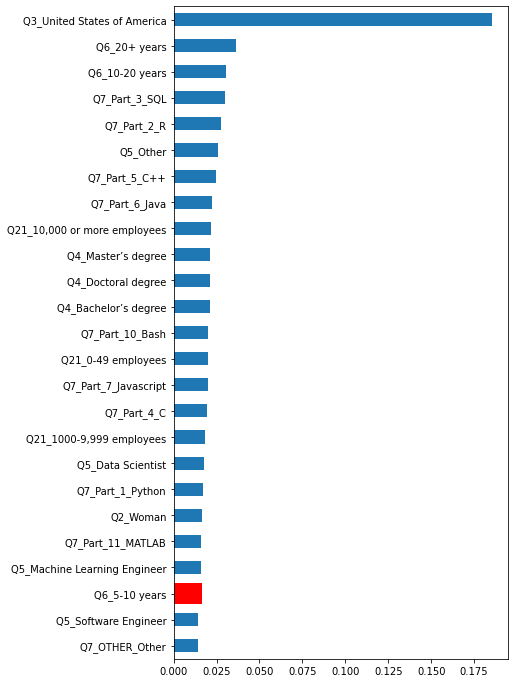

In [56]:
feat_importances = pd.Series(clf_rf.feature_importances_, index=X.columns)
ax  = feat_importances.nlargest(25).sort_values().plot(kind='barh', figsize=(6,12))
ax.barh([2],feat_importances.loc['Q2_Woman'],color='red')

In [57]:
#build models for men and women independently. See how they estimate salary on the same data 
#I think this is a decent way to isolate individual effects of education, country, etc.
Women_Model = model_dummies[model_dummies.Q2_Man == 0]
Men_Model = model_dummies[model_dummies.Q2_Man == 1]

In [63]:
# create and train women's model 
women_fin =  qnums(['Q4','Q5','Q7','Q3','Q6','Q21'], Women_Model)
Y_W = Women_Model.aprox_salary
X_W = women_fin
X_W = sm.add_constant(X_W)

Women_Model

salary_min  salary_max  aprox_salary  Q1_18-21  Q1_22-24  Q1_25-29  \
22           1000        1999        1499.5         0         0         1   
26          25000       29999       27499.5         0         0         1   
29              0         999         499.5         0         1         0   
34           7500        9999        8749.5         0         0         0   
44           4000        4999        4499.5         0         0         0   
...           ...         ...           ...       ...       ...       ...   
25887        4000        4999        4499.5         0         0         0   
25916           0         999         499.5         1         0         0   
25926       90000       99999       94999.5         0         0         1   
25943           0         999         499.5         1         0         0   
25953       15000       19999       17499.5         0         0         1   

       Q1_30-34  Q1_35-39  Q1_40-44  Q1_45-49  Q1_50-54  Q1_55-59  Q1_60-69  \
22            0         0         0         0         0         0         0   
26            0         0         0         0         0         0         0   
29            0         0         0         0         0         0         0   
34            1         0         0         0         0         0         0   
44            1         0         0         0         0         0         0   
...         ...       ...       ...       ...       ...       ...       ...   
25887         0         1         0         0         0         0         0   
25916         0         0         0         0         0         0         0   
25926         0         0         0         0         0         0         0   
25943         0         0         0         0         0         0         0   
25953         0         0         0         0         0         0         0   

       Q1_70+  Q2_Man  Q2_Woman  Q3_Algeria  Q3_Argentina  Q3_Australia  \
22          0       0         1           0             0             0   
26          0       0         1           0             0             0   
29          0       0         1           0             0             0   
34          0       0         1           0             0             0   
44          0       0         1           0             0             0   
...       ...     ...       ...         ...           ...           ...   
25887       0       0         1           0             0             0   
25916       0       0         1           0             0             0   
25926       0       0         1           0             0             0   
25943       0       0         1           0             0             0   
25953       0       0         1           0             0             0   

       Q3_Austria  Q3_Bangladesh  Q3_Belarus  Q3_Belgium  Q3_Brazil  \
22              0              0           0           0          0   
26              0              0           0           0          0   
29              0              0           0           0          0   
34              0              0           0           0          0   
44              0              0           0           0          0   
...           ...            ...         ...         ...        ...   
25887           0              0           0           0          0   
25916           0              0           0           0          0   
25926           0              0           0           0          0   
25943           0              0           0           0          0   
25953           0              0           0           0          0   

       Q3_Canada  Q3_Chile  Q3_China  Q3_Colombia  Q3_Czech Republic  \
22             0         0         0            0                  0   
26             0         0         0            0                  0   
29             0         0         0            0                  0   
34             0         0         0            0                  0   
44             0   

In [64]:
model_W = sm.OLS(Y_W,X_W)
results_W= model_W.fit()
results_W.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           aprox_salary   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     12.18
Date:                Sat, 29 Jan 2022   Prob (F-statistic):          1.19e-155
Time:                        14:46:52   Log-Likelihood:                -30097.
No. Observations:                2482   AIC:                         6.041e+04
Df Residuals:                    2375   BIC:                         6.103e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                 2.195e+04   2487.873      8.824      0.000    1.71e+04    2.68e+04
Q4_Bachelor’s degree                                                    70.9529   2598.061      0.027      0.978   -5023.749    5165.655
Q4_Doctoral degree                                                    9558.3005   3021.893      3.163      0.002    3632.480    1.55e+04
Q4_I prefer not to answer                                            -4936.6584   5256.087     -0.939      0.348   -1.52e+04    5370.336
Q4_Master’s degree                                                    3829.6236   2376.900      1.611      0.107    -831.389    8490.637
Q4_No formal education past high school                              -2537.6233   9734.518     -0.261      0.794   -2.16e+04    1.66e+04
Q4_Professional doctorate                                             1.067e+04   5593.809      1.907      0.057    -300.296    2.16e+04
Q4_Some college/university study without earning a bachelor’s degree  5298.7492   4632.035      1.144      0.253   -3784.501    1.44e+04
Q5_Business Analyst                                                   1926.1498   3858.294      0.499      0.618   -5639.824    9492.123
Q5_DBA/Database Engineer                                             -1.284e+04      1e+04     -1.281      0.200   -3.25e+04    6818.146
Q5_Data Analyst                                                        402.3613   2668.161      0.151      0.880   -4829.804    5634.526
Q5_Data Engineer                                                     -5687.6452   5026.733     -1.131      0.258   -1.55e+04    4169.595
Q5_Data Scientist                                                     4378.2279   2599.058      1.685      0.092    -718.429    9474.885
Q5_Developer Relations/Advocacy                                       1.009e+04   1.14e+04      0.885      0.376   -1.23e+04    3.24e+04
Q5_Machine Learning Engineer                                          9231.9126   4004.542      2.305      0.021    1379.153    1.71e+04
Q5_Other                                                             -1376.5920   2795.534     -0.492      0.622   -6858.531    4105.347
Q5_Product Manager                                                    2.853e+04   6989.086      4.082      0.000    1.48e+04    4.22e+04
Q5_Program/Project Manager                                            3249.6120   4931.357      0.659      0.510   -6420.598    1.29e+04
Q5_Research Scientist                                                -5490.7837   3503.820     -1.567      0.117   -1.24e+04    1380.080
Q5_Software Engineer                                                 

In [65]:
results_reg_W = model_W.fit_regularized(L1_wt=1, alpha= 5)
final_W = sm.regression.linear_model.OLSResults(model_W,results_reg_W.params,model_W.normalized_cov_params)
print(final_W.summary())

                            OLS Regression Results                            
Dep. Variable:           aprox_salary   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     12.17
Date:                Sat, 29 Jan 2022   Prob (F-statistic):          1.79e-155
Time:                        14:47:36   Log-Likelihood:                -30098.
No. Observations:                2482   AIC:                         6.041e+04
Df Residuals:                    2375   BIC:                         6.103e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [67]:
#create and train men's model 
men_fin =  qnums(['Q4','Q5','Q7','Q3','Q6','Q21'], Men_Model)
Y_M = Men_Model.aprox_salary
X_M = men_fin
X_M = sm.add_constant(X_M)

model_M = sm.OLS(Y_M,X_M)
results_M= model_M.fit()
results_M.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           aprox_salary   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     63.13
Date:                Sat, 29 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:48:30   Log-Likelihood:            -1.5684e+05
No. Observations:               12642   AIC:                         3.139e+05
Df Residuals:                   12535   BIC:                         3.147e+05
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
========================================================================================================================================
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                 2.494e+04   1345.658     18.535      0.000    2.23e+04    2.76e+04
Q4_Bachelor’s degree                                                  1579.4603   1356.682      1.164      0.244   -1079.845    4238.765
Q4_Doctoral degree                                                    1.033e+04   1725.617      5.989      0.000    6952.310    1.37e+04
Q4_I prefer not to answer                                             -824.9925   3451.487     -0.239      0.811   -7590.436    5940.451
Q4_Master’s degree                                                    4434.8918   1240.689      3.575      0.000    2002.951    6866.833
Q4_No formal education past high school                              -1261.0435   3753.050     -0.336      0.737   -8617.596    6095.509
Q4_Professional doctorate                                             9475.3677   3625.335      2.614      0.009    2369.156    1.66e+04
Q4_Some college/university study without earning a bachelor’s degree  1203.8227   2302.013      0.523      0.601   -3308.475    5716.121
Q5_Business Analyst                                                    711.9953   2271.045      0.314      0.754   -3739.601    5163.591
Q5_DBA/Database Engineer                                             -1.228e+04   5025.009     -2.443      0.015   -2.21e+04   -2426.965
Q5_Data Analyst                                                      -8778.7212   1707.319     -5.142      0.000   -1.21e+04   -5432.114
Q5_Data Engineer                                                     -1993.9812   2636.733     -0.756      0.450   -7162.381    3174.419
Q5_Data Scientist                                                     6828.5994   1442.420      4.734      0.000    4001.236    9655.963
Q5_Developer Relations/Advocacy                                        1.29e+04   6807.538      1.895      0.058    -444.898    2.62e+04
Q5_Machine Learning Engineer                                          3866.1003   1909.647      2.025      0.043     122.900    7609.301
Q5_Other                                                              5160.1066   1605.723      3.214      0.001    2012.643    8307.571
Q5_Product Manager                                                     2.74e+04   3690.298      7.425      0.000    2.02e+04    3.46e+04
Q5_Program/Project Manager                                            1.051e+04   2290.673      4.590      0.000    6024.293     1.5e+04
Q5_Research Scientist                                                -9528.3544   2063.405     -4.618      0.000   -1.36e+04   -5483.765
Q5_Software Engineer                                                 

In [68]:
results_reg_M = model_M.fit_regularized(L1_wt=1, alpha= 5)
final_M = sm.regression.linear_model.OLSResults(model_M,results_reg_M.params,model_M.normalized_cov_params)
print(final_M.summary())

                            OLS Regression Results                            
Dep. Variable:           aprox_salary   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     63.10
Date:                Sat, 29 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:48:59   Log-Likelihood:            -1.5684e+05
No. Observations:               12642   AIC:                         3.139e+05
Df Residuals:                   12535   BIC:                         3.147e+05
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [70]:
#run model on all data & compare 
combined_data = qnums(['Q4','Q5','Q7','Q3','Q6','Q21'], model_dummies)
male_preds = final_M.predict(np.array(sm.add_constant(combined_data)))
female_preds = final_W.predict(np.array(sm.add_constant(combined_data)))

In [71]:
combined_data['male_preds'] = male_preds
combined_data['female_preds'] = female_preds

In [72]:
combined_data['aprox_salary'] = model_dummies.aprox_salary
combined_data

Q4_Bachelor’s degree  Q4_Doctoral degree  Q4_I prefer not to answer  \
1                         1                   0                          0   
2                         0                   0                          0   
3                         0                   0                          0   
4                         0                   1                          0   
5                         0                   1                          0   
...                     ...                 ...                        ...   
25967                     1                   0                          0   
25968                     1                   0                          0   
25969                     1                   0                          0   
25971                     0                   1                          0   
25973                     1                   0                          0   

       Q4_Master’s degree  Q4_No formal education past high school  \
1                       0                                        0   
2                       1                                        0   
3                       1                                        0   
4                       0                                        0   
5                       0                                        0   
...                   ...                                      ...   
25967                   0                                        0   
25968                   0                                        0   
25969                   0                                        0   
25971                   0                                        0   
25973                   0                                        0   

       Q4_Professional doctorate  \
1                              0   
2                              0   
3                              0   
4                              0   
5                              0   
...                          ...   
25967                          0   
25968                          0   
25969                          0   
25971                          0   
25973                          0   

       Q4_Some college/university study without earning a bachelor’s degree  \
1                                                      0                      
2                                                      0                      
3                                                      0                      
4                                                      0                      
5                                                      0                      
...                                                  ...                      
25967                                                  0                      
25968                                                  0                      
25969                                                  0                      
25971                                                  0                      
25973                                                  0                      

       Q5_Business Analyst  Q5_DBA/Database Engineer  Q5_Data Analyst  \
1                        0                         0                0   
2                        0                         0                0   
3                        0                         0                0   
4                        0                         0                0   
5                        0                         0                0   
...                    ...                       ...              ...   
25967                    0                         0                1   
25968                    0                         0                0   
25969                    0                         0                1   
25971                    0                         0                0   
25973                    1                  

In [73]:
px.scatter(combined_data.sort_values('aprox_salary'), x = 'aprox_salary', y = ['male_preds','female_preds'])

In [74]:
model_comp = sm.OLS(combined_data['male_preds'],sm.add_constant(combined_data['female_preds']))
results_comp = model_comp.fit()
results_comp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             male_preds   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 1.250e+05
Date:                Sat, 29 Jan 2022   Prob (F-statistic):               0.00
Time:                        14:53:55   Log-Likelihood:            -1.6606e+05
No. Observations:               15124   AIC:                         3.321e+05
Df Residuals:                   15122   BIC:                         3.321e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3558.8614    162.006     21.967      0.000    3241.309    3876.413
female_preds     1.2596      0.004    353.587      0.000       1.253       1.267
==============================================================================
Omnibus:                     2120.042   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11810.827
Skew:                          -0.554   Prob(JB):                         0.00
Kurtosis:                       7.185   Cond. No.                     6.38e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- **The male_model is predicting approx. 2% higher than the female_model salary is**

In [75]:
combined_data['projected_diff'] = combined_data.male_preds - combined_data.female_preds

In [76]:
combined_data.projected_diff.mean()

11842.334632619079

In [77]:
combined_data.projected_diff.std()

16500.459478015713

In [78]:
combined_data['women_prj_higher'] = combined_data.projected_diff.apply(lambda x: 1 if x < 0 else 0)

In [79]:
combined_data.women_prj_higher.value_counts()

0    11888
1     3236
Name: women_prj_higher, dtype: int64